In [247]:
from tqdm import tqdm
import numpy as np
import pandas as pd



Let's pretend that Max Scherzer wakes up tomorrow in a flat, featureless pocket universe. 

Let's agree that this place:

- Has a windless, Earth-like atmosphere set to STP;
- is subject to Earth-like gravity (9.807 m/s<sup>2</sup>);
- and isn't Cleveland.

Let's also state the obvious: Max wants to go home.

To Max's left is a Pandas DataFrame made manifest, which describes — in agonizing detail — every pitch he has ever thrown in the Major Leagues.

To Max's right is a surveyor's wheel, a granola bar, and a gold tablet, upon which, in Comic Sans, is writ a set of instructions:

Hi Max:

Per my previous email: 

Welcome to <s>Cleveland</s> Nowhere. In order to leave, you must:
1. Reference the DataFrame
2. Re-throw the 1<sup>st</sup> pitch you threw in the Bigs
3. At a 45° angle
4. Survey-wheel on over where the ball lands
5. Record the distance you've walked
6. Reference the DataFrame
7. Re-throw the 2<sup>nd</sup> pitch you threw in the Bigs
8. At a 45° angle
9. Survey-wheel on over to where the ball lands
10. ...
11. Re-throw the 43,815<sup>th</sup> pitch you threw in the Bigs
12. At a 45° angle.
13. Announce, out loud, how far you've walked in total.
14. I already know the cumulative distance, but I need you to check my work.
15. Thanks!

Let's also agree that Max, being the generational pitching talent that he is, is able to throw a ball precisely as fast as he wants, and at an exact 45° angle.

And also let's agree doesn't need to sleep or eat or drink or pee here, and his arm never gets tired, and any other nullifying pedantry is also negated in full in the context of this ridiculous thought experiment.

So! Here's how far Max can go.


In [248]:
# Data avenue 1:
# https://baseballsavant.mlb.com/savant-player/max-scherzer-453286?stats=statcast-r-pitching-mlb#pitch_tracking

# Data avenue 2:
# https://baseballsavant.mlb.com/statcast_search?hfPT=&hfAB=&hfGT=R%7C&hfPR=&hfZ=&stadium=&hfBBL=&hfNewZones=&hfPull=&hfC=&hfSea=2022%7C2021%7C2020%7C2019%7C2018%7C2017%7C2016%7C2015%7C2014%7C2013%7C2012%7C2011%7C2010%7C2009%7C2008%7C&hfSit=&player_type=pitcher&hfOuts=&opponent=&pitcher_throws=&batter_stands=&hfSA=&game_date_gt=&game_date_lt=&hfMo=&team=&home_road=&hfRO=&position=&hfInfield=&hfOutfield=&hfInn=&hfBBT=&hfFlag=&pitchers_lookup%5B%5D=453286&metric_1=&group_by=name&min_pitches=0&min_results=0&min_pas=0&sort_col=pitches&player_event_sort=api_p_release_speed&sort_order=desc#results

# Note about second link: For whatever reason, Savant isn't including 2008-9 in this data export. But the data does exist. So a separate search for 2008-9 and then a merge or a cut/paste into 2010-22 yields the final csv, which I've included in the repo.

df = pd.read_csv('data/scherzer_pitches.csv')

/var/folders/m9/kw6252cj3lqgftmsg97nw4z80000gn/T/ipykernel_88184/1694380553.py:9: DtypeWarning: Columns (43,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/scherzer_pitches.csv')


In [249]:
df = df.convert_dtypes()
df.columns

Index(['pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
       'estima

In [250]:
# Converting the release speed from mph to m/s
df['mps'] = df['release_speed'] * 0.44704

This thought experiment is a simple summing of an iterative projectile motion solve for distance, more or less. Thankfully, the field of basic mechanics is pretty well codified.

Double-thankfully, people smarter than me have already translated basic mechanics into Python. So all I have to do is steal.

And by steal, I mean I'll be referencing other folks and trying to color inside their lines.


### Sources I've <s>Stolen</s> Learned From, to Whom This Nonsense Owes A Substantial Debt That Shall Never Be Repaid

[NASA's Entire Fucking Webpage About Modeling Baseball Dynamics](https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/aerodynamics-of-baseball/)

[Matthew West](https://dynref.engr.illinois.edu/afp.html)

[Jerron Lim](https://cocalc.com/share/public_paths/223c4e9ca1b913a9fa9d1d0f1028d90b7dc0b2d2)

[Allen Downey](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/chapters/chap22.ipynb)

---


## Describing the Problem

### Part A: The Stuff
We need to know:
1. The baseball's mass
2. The baseball's diameter
3. Acceleration due to gravity
4. Initial velocities (direction and magnitude)
5. Drag coefficient

#### Hard stuff first: Drag coefficient

There are two reasons why most high school physics classrooms only consider gravity when attacking basic mechanics:
1. Science teachers love writing space-themed fanfic, and it's super fun to **pretend all of your problems in life exist in a vacuum**.
2. All of the non-gravitational forces are ***complicated***. 

But we're not in high school at the moment. 

So we're gonna try to Mr. Wizard some **air resistance** for Max and his Task, because he's made about $320 million playing baseball and he can catch a tough break for once in his incredible life.

## Drag Forces and Coefficients

**Drag force** is pretty simple in the realm of basic mechanics. Here's the equation we're going to end up using:

$$ \vec{F}_{\rm D} = -F_{\rm D} \hat{v}, $$

But let's work through how it's derived.

The first part of our drag force equation, $ \vec{F}_{\rm D} $, is described by a **dimensionless drag coefficient** $ C_{\rm D} $, which is itself described by this ugliness:

$$ C_{\rm D} = \frac{F_{\rm D}}{\frac{1}{2} \rho A v^2} $$

It's not actually that ugly, though.

- $\rho$ = our air's **density**. (Technically: the density of the environmental fluid. And our <s>Cleveland</s> pocket universe is full of STP air.)
- $A$ = our baseball's **cross-sectional area**, which we can figure out with this badass equation: $\frac{1}{4}\pi D^2$
- $v$ = how hard Max throws the ball. E.g., its **initial velocity**.

### Meet our new best friend: the Reynolds number. 

Here's what she looks like.

$$ {\rm Re} = \frac{\rho v L}{\mu} $$

She, like our **drag coefficient**, is far from ugly: 
- $L$ = **Characteristic length of flow** — which, in this <s>Cleveland</s> thought experiment, is the diameter of the baseball $D$.
- $\mu$ = Our air's **dynamic viscosity**.

*The Reynolds number* can be thought of as **the link between our baseball's intertial forces and our air's viscous forces**.

It's important to note that when we're running our numbers, **we only care about the fluid forces that interact directly with our baseball**, as is described with this cute lil guy: $$ C_{\rm D} = C_{\rm D}({\rm Re}) $$
Basically, we're not trying to split the atom. We're trying to run Max through the ringer. 

Fluid dynamics can get super complicated faster than I can get a **C- in AP Chemistry**, but we're able to figure out a reasonable solve for our baseball's flight without spending big money on cloud compute — just to overcomplicate our lives into oblivion for the sake of a negligible increase in accuracy. 

And besides: our <s>Cleveland</s> MaxWorld™ is an infinite, windless doldrum. So we can ignore any "real" fluid dynamics on principle.

But getting back to our cute lil $ C_{\rm D} = C_{\rm D}({\rm Re}) $ ... 

### NASA to the Rescue

NASA gathered a ton of experimental data about projectiles in flight to try to quantify and chart the relationship between the Reynolds number and drag coefficients. 

The important thing here is the flat part of the chart, which is positioned more or less above $10^4$.

This is telling us that in this region of Newtonian spaghetti, drag force is proportional to the square of our baseball's speed.

![I Can't Believe NASA Did This](images/nasa-baseball-drag.jpeg)

Credit: [NASA](https://www1.grc.nasa.gov/beginners-guide-to-aeronautics/drag-of-a-sphere/)



https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/chapters/chap22.ipynb

Allen Downey

In [259]:
#import units
from pint import UnitRegistry
from os.path import basename, exists
units = UnitRegistry()

In [260]:
def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')

Downloaded modsim.py


In [261]:
#import functions from modsim

from modsim import *

In [105]:
A = Vector(3,4)
show(A)

,component
x,3
y,4


In [106]:
mag = vector_mag(A)
theta = vector_angle(A)
mag, theta

(5.0, 0.9272952180016122)

In [262]:
from numpy import rad2deg
from numpy import deg2rad

In [263]:
angle = rad2deg(theta)
angle

NameError: name 'theta' is not defined

In [110]:
theta = deg2rad(angle)
theta

0.9272952180016122

In [111]:
x, y = pol2cart(theta, mag)
C = Vector(x, y)
show(C)

,component
x,3.0
y,4.0


In [264]:
MPH_TO_METSEC = 0.44704

In [265]:
params = Params(
    x = 0,   # m
    y = 1,    #m
    angle = 45,  # degree
    speed = (100 * MPH_TO_METSEC),
    mass = 145e-3,  # KG
    diameter = 73e-3, # m
    C_d = 0.33,  # dimensionless
    
    rho = 1.2,  # kg/m**3
    g = 9.8,  # m/s**2
    t_end = 10   # s
)

In [266]:
from numpy import pi, deg2rad

def make_system(params):
    
    # convert angle to degrees
    theta = deg2rad(params.angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, params.speed)
    
    # make the initial state
    init = State(x=params.x, y=params.y, vx=vx, vy=vy)
    
    # compute the frontal area
    area = pi * (params.diameter/2)**2

    return System(params,
                  init = init,
                  area = area)

In [267]:
system = make_system(params)

In [268]:
show(system.init)

,state
x,0.000000
y,1.000000
vx,31.610502
vy,31.610502


In [269]:
def drag_force(V, system):
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * vector_mag(V)**2 * C_d * area / 2
    direction = -vector_hat(V)
    f_drag = mag * direction
    return f_drag

In [270]:
vx, vy = system.init.vx, system.init.vy
V_test = Vector(vx, vy)
f_drag = drag_force(V_test, system)
show(f_drag)

,component
x,-1.171058
y,-1.171058


In [121]:
def slope_func(t, state, system):
    x, y, vx, vy = state
    mass, g = system.mass, system.g
    
    V = Vector(vx, vy)
    a_drag = drag_force(V, system) / mass
    a_grav = g * Vector(0, -1)
    
    A = a_grav + a_drag
    
    return V.x, V.y, A.x, A.y

In [271]:
slope_func(0, system.init, system)

NameError: name 'slope_func' is not defined

In [123]:
def event_func(t, state, system):
    x, y, vx, vy = state
    return y

In [124]:
event_func(0, system.init, system)

1.0

In [125]:
results, details = run_solve_ivp(system, slope_func,
                                 events=event_func)
details.message

'A termination event occurred.'

In [126]:
results.tail()

,x,y,vx,vy
5.213491,110.636544,4.951837,14.692043,-22.185851
5.267798,111.429951,3.741565,14.570794,-22.533515
5.322106,112.216750,2.512704,14.449575,-22.876813
5.376413,112.996957,1.265450,14.328405,-23.215732
5.430720,113.770588,0.000000,14.207304,-23.550263


In [146]:
flight_time = results.index[-1]
flight_time * career_pitches

390094.0458188174

In [128]:
final_state = results.iloc[-1]
show(final_state)

,5.43072
x,113.770588
y,0.000000
vx,14.207304
vy,-23.550263


In [145]:
x_dist = final_state.x
x_dist * career_pitches

8172255.095116312

In [131]:
final_V = Vector(final_state.vx, final_state.vy)
show(final_V)

,component
x,14.207304
y,-23.550263


In [134]:
vector_mag(final_V)

27.50386147321765

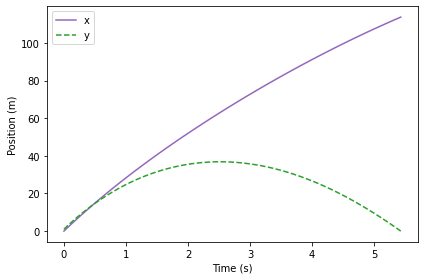

In [135]:
results.x.plot(color='C4')
results.y.plot(color='C2', style='--')

decorate(xlabel='Time (s)',
         ylabel='Position (m)')

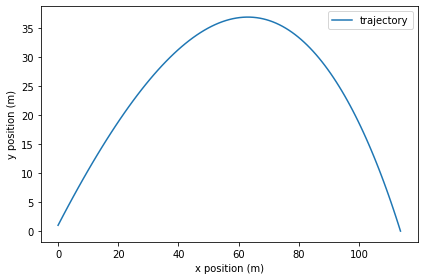

In [136]:
def plot_trajectory(results):
    x = results.x
    y = results.y
    make_series(x, y).plot(label='trajectory')

    decorate(xlabel='x position (m)',
             ylabel='y position (m)')

plot_trajectory(results)

In [137]:
rad2deg(vector_angle(final_V))

-58.89843584813188

In [138]:
young['pitches_per_batter'] = young['total_pitches'] / young['TBF']

In [140]:
mean_pitches_pb = young['pitches_per_batter'].mean()

In [139]:
young.pitches_per_batter.describe()

count    20.000000
mean      3.772570
std       0.390126
min       3.137269
25%       3.531897
50%       3.825607
75%       3.965771
max       4.485597
Name: pitches_per_batter, dtype: float64

In [144]:
young['balls_approx'] = young['total_pitches'] - young['SO'] * mean_pitches_pb

377     2806.105562
736     2352.456329
294     2746.553516
286     2687.406009
398     3084.466687
64       3009.82436
961       3017.3695
1065    2394.763682
1234    2864.716815
1379    2398.131713
417     2177.168222
954     3060.485933
1478      3026.5328
554     2526.803644
3       1760.840153
706     2890.720268
488     2470.619629
1142    2736.853964
930     2538.121355
1076    2350.301918
dtype: Float64